# Eluvio Data Science and Machine Learning Internship Assessment - Summer 2021

In [1]:
import pandas as pd
import numpy as np

import datetime 
from datetime import date
import calendar
import time 

from geotext import GeoText

import seaborn as sns
import matplotlib.pyplot as plt

from collections import Counter

import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer,WordNetLemmatizer
nltk.download('vader_lexicon')
nltk.download('wordnet')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

import spacy

from wordcloud import WordCloud

import re

In D:\Anaconda\application\envs\nlp_course\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In D:\Anaconda\application\envs\nlp_course\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The verbose.level rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In D:\Anaconda\application\envs\nlp_course\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\jayga\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\jayga\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


D:\Anaconda\application\envs\nlp_course\lib\site-packages\nltk\twitter\__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


## 1. Loading Data

In [2]:
df = pd.read_csv("Eluvio_DS_Challenge.csv")
df.head()               

,time_created,date_created,up_votes,down_votes,title,over_18,author,category
0,1201232046,2008-01-25,3,0,Scores killed in Pakistan clashes,False,polar,worldnews
1,1201232075,2008-01-25,2,0,Japan resumes refuelling mission,False,polar,worldnews
2,1201232523,2008-01-25,3,0,US presses Egypt on Gaza border,False,polar,worldnews
3,1201233290,2008-01-25,1,0,Jump-start economy: Give health care to all,False,fadi420,worldnews
4,1201274720,2008-01-25,4,0,Council of Europe bashes EU&UN terror blacklist,False,mhermans,worldnews


Simply looking at the columns we can conclude that the dataset is related to world news. Also, we have a column that tells us the news published has adult content [Column: 'over_18'].

## 2. Cleaning Data

In [3]:
# Check for null values in the dataset.
print(df.isnull().sum())
print('------------------------------------')
#Remove duplicate rows if any.
duplicateRowsDF = df[df.duplicated()]
print(f'Number of duplicated data rows: {len(duplicateRowsDF)}') # 6 rowns were duplicate.
df = df.drop_duplicates() #remove all the duplicaed rows.

time_created    0
date_created    0
up_votes        0
down_votes      0
title           0
over_18         0
author          0
category        0
dtype: int64
------------------------------------
Number of duplicated data rows: 6


Now the dataframe is free from null values and duplicated rows.

## 3. Understanding the Data

In [4]:
# finding the distinct values for the columns.
time = set(df['time_created'])
print(f'Number of distinct Time stamps: {len(time)}')

date = set(df['date_created'])
print(f'Number of distinct Dates: {len(date)}')

#convert days to year, month, days
print(f'Time line of the dataset: {len(date)//365} years, {(len(date)%365)//30} months and {((len(date)%365)%30)} days.')

upvote = set(df['up_votes'])
print(f'Distinct values for Upvotes: {len(upvote)}')

downvote = set(df['down_votes'])
print(f'Distinct values for Downvotes: {len(downvote)}, {downvote}') # no downvotes in the dataset.

title = set(df['title'])
print(f'Number of Titles: {len(title)}') 

author = set(df['author'])
print(f'Number of Authors: {len(author)}')

age = set(df['over_18'])
print(f'Distinct values for Above 18 rated content: {len(age)}, {age}')

category = set(df['category'])
print(f'Number of Category: {len(category)}, {category}')

print(f'Total Length of the dataset: {len(df.index)}')

Number of distinct Time stamps: 508329
Number of distinct Dates: 3223
Time line of the dataset: 8 years, 10 months and 3 days.
Distinct values for Upvotes: 5782
Distinct values for Downvotes: 1, {0}
Number of Titles: 500720
Number of Authors: 85838
Distinct values for Above 18 rated content: 2, {False, True}
Number of Category: 1, {'worldnews'}
Total Length of the dataset: 509230


From the above information we know that:
1. The dataset records approximately 9 years of world news in ***chronological order***.
2. The column 'category' and 'down_votes' have only one value i.e. 'worldnews' and '0' respectively. We can simply drop that column from our analysis.
3. Number of titles is not equal to the number of rows in the dataframe. As we have already removed all the duplicate enteries from the dataframe, this suggests that the same titles of the news is published at different time stamps or by different authors. Since the number of time stamps are more than the number of titles, this also suggests that most likely multiple authors have posted exact news at different time stamps.

In [5]:
#addressing point 2
df = df.drop(columns=['category', 'down_votes'])
df.head()

,time_created,date_created,up_votes,title,over_18,author
0,1201232046,2008-01-25,3,Scores killed in Pakistan clashes,False,polar
1,1201232075,2008-01-25,2,Japan resumes refuelling mission,False,polar
2,1201232523,2008-01-25,3,US presses Egypt on Gaza border,False,polar
3,1201233290,2008-01-25,1,Jump-start economy: Give health care to all,False,fadi420
4,1201274720,2008-01-25,4,Council of Europe bashes EU&UN terror blacklist,False,mhermans


## Analysis 1: Plagiarism Checker
From point 3, we get the motivation to find authors that have plagiarised the posts. Since the data is in chronological order, using pandas we can mark the titles that are duplicated after their first occurance.

In [6]:
#addressing point 
df['plagiarised'] = df.duplicated(subset=['title'], keep=False)
#all duplicated titles are marked 'True' in the 'plagiarised' column.
df.head() 

,time_created,date_created,up_votes,title,over_18,author,plagiarised
0,1201232046,2008-01-25,3,Scores killed in Pakistan clashes,False,polar,False
1,1201232075,2008-01-25,2,Japan resumes refuelling mission,False,polar,False
2,1201232523,2008-01-25,3,US presses Egypt on Gaza border,False,polar,False
3,1201233290,2008-01-25,1,Jump-start economy: Give health care to all,False,fadi420,False
4,1201274720,2008-01-25,4,Council of Europe bashes EU&UN terror blacklist,False,mhermans,False


In [7]:
#create a new dataframe with all the plagirised titles.
df_plag_posts = df.loc[df['plagiarised'] == True] 
print(f'There are {len(df_plag_posts)} posts plagirised')
#count the number of times each author has plagiarised. 
count_authors_plag_post = dict(df_plag_posts['author'].value_counts())
print(f'{len(count_authors_plag_post)} authors out of {len(author)} in total have published plagrised posts.')
print(f'-> {round((len(count_authors_plag_post)/len(author))*100,2)}% authors have published plagirised news')
print(f'-> {round((len(df_plag_posts)/len(title))*100,2)}% title published are plagirised.')
print('-----------------------------------------------------------------')
top10_plag_authors = list(count_authors_plag_post.items())[:10]
top10_plag_authors_names = []
for each_tup in top10_plag_authors:
    top10_plag_authors_names.append(each_tup[0])
print('Top 10 authors with plagirised news:')
print('    Name                Plagirised Post Count')
i = 1 #counter var
for key_name, value_plag_count in top10_plag_authors:
    print(f'{i:3}.{key_name:20} {value_plag_count:10}')
    i += 1
del i

There are 16229 posts plagirised
7523 authors out of 85838 in total have published plagrised posts.
-> 8.76% authors have published plagirised news
-> 3.24% title published are plagirised.
-----------------------------------------------------------------
Top 10 authors with plagirised news:
    Name                Plagirised Post Count
  1.scienceben                  157
  2.nimobo                      106
  3.bob21doh                    102
  4.readerseven                  99
  5.DoremusJessup                88
  6.emr1028                      67
  7.conuly                       58
  8.redhatGizmo                  53
  9.zsreport                     53
 10.User_Name13                  50


With this piece of information, some action can be taken on the authors like suspending their account.


# 4. Feature Extraction
Let us extract features from the dataframe cloumns. 

From the column 'date_created' we can get: year, date, month and day. From day we can determine if it is a weekend or a weekday.

From column 'time_created' we can extract the day time.

From column 'title' we can extract the countries and cities mentioned in the title as the dataset is of world news. This can be important piece of information. Also, lenth of the title, i.e. number of words in the title. 


In [8]:
#function to determine country from the title
def countries(x):
    count = GeoText(x).countries
    city = GeoText(x).cities
    w = ''
    if not count and not city:
        return np.nan
    else:
        for country in count:
            w = w+' '+country
        for c in city:
            w = w+' '+c
        return w
#function to determine city from the title
def places(x):
    count = GeoText(x).countries
    city = GeoText(x).cities
    w = 0
    if not count and not city:
        return 0
    else:
        w=len(count)+len(city)
        return w 
#function to extract features
def df_feature_extraction(df):
    df['date_created'] = pd.to_datetime(df['date_created']) #convert to date-time format for feature extraction
    df['day_of_week']=df['date_created'].dt.day_name() #get day
    df['day_of_week_num']=df['date_created'].dt.dayofweek #assign number to each day
    df['year'] = df['date_created'].dt.year #get year 
    df['month'] = df['date_created'].dt.month #get month 
    df['day'] = df['date_created'].dt.day #get date of the month
    df['weekend'] = np.where(df['date_created'].dt.dayofweek>4, 1, 0) #if weekend assign 1 else 0
    # Unix tim starts at 00:00:00 Thursday, 1 January 1970
    df['time_created'] = pd.to_datetime(df['time_created'], unit='s') #convert to date time format
    df['day_time']=df['time_created'].dt.hour+df['time_created'].dt.minute/60+df['time_created'].dt.second/3600 #convert to 24hr time format           
    df['author_total_posts'] = df['author'].groupby(df['author']).transform('count') #author total post count
    df['title_length'] = df['title'].str.split().apply(len) #get number of words inthe title
    df['over_18'] = df['over_18'].map({False:0,True:1}) #convert False to 0 and True to 1
    df['countries'] = df['title'].apply(lambda x: countries(x)) #get country names
    df['places'] = df['title'].apply(lambda x: places(x)) #get city names
    return df

In [9]:
df_copy = df_feature_extraction(df)
df_copy = df_copy.sort_values(['time_created'], ascending=True) #arrange data in ascending order
df_copy.head()

,time_created,date_created,up_votes,title,over_18,author,plagiarised,day_of_week,day_of_week_num,year,month,day,weekend,day_time,author_total_posts,title_length,countries,places
0,2008-01-25 03:34:06,2008-01-25,3,Scores killed in Pakistan clashes,0,polar,False,Friday,4,2008,1,25,0,3.568333,50,5,Pakistan,1
1,2008-01-25 03:34:35,2008-01-25,2,Japan resumes refuelling mission,0,polar,False,Friday,4,2008,1,25,0,3.576389,50,4,Japan,1
2,2008-01-25 03:42:03,2008-01-25,3,US presses Egypt on Gaza border,0,polar,False,Friday,4,2008,1,25,0,3.700833,50,6,Egypt Gaza,2
3,2008-01-25 03:54:50,2008-01-25,1,Jump-start economy: Give health care to all,0,fadi420,False,Friday,4,2008,1,25,0,3.913889,2,7,NaN,0
4,2008-01-25 15:25:20,2008-01-25,4,Council of Europe bashes EU&UN terror blacklist,0,mhermans,False,Friday,4,2008,1,25,0,15.422222,1,7,NaN,0


## Analysis 2: Most Active Author Trends
Most active = authors with maximum number of posts.

We have the dataset in chronological order. Leveraging this to our advantage, we can find out the trends of author activity with respect to days of the week and year.

[Text(0, 0.5, 'Post Count'), Text(0.5, 0, 'Years')]

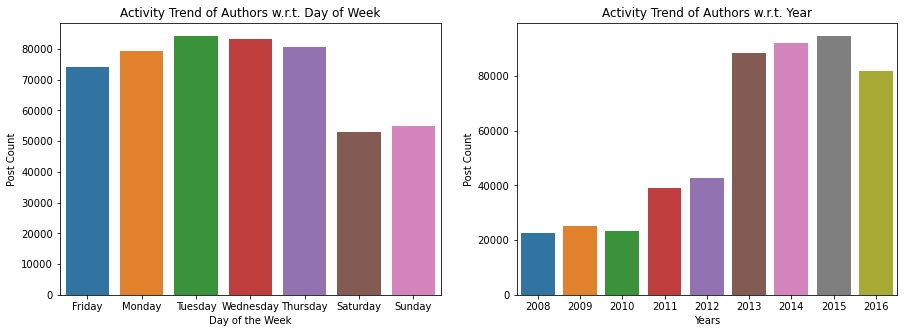

In [129]:
#plottig trends for all authors post count v/s days of the week and year
f, ax = plt.subplots(1, 2, figsize=(15, 5))
g1=sns.countplot(x='day_of_week',data=df_copy,ax=ax[0])
g1.set_title('Activity Trend of Authors w.r.t. Day of Week')
g1.set(xlabel='Day of the Week', ylabel='Post Count')
g2 =sns.countplot(x='year',data=df_copy,ax=ax[1])
g2.set_title('Activity Trend of Authors w.r.t. Year')
g2.set(xlabel='Years', ylabel='Post Count')

From the above graph it is clear that the authors posting frequency is less during the weekends (Saturday and Sunday) compared to weekdays. 
Also, there is an increase in the number of posts with time (years).

[Text(0, 0.5, 'Author Names'), Text(0.5, 0, 'Number of Posts')]

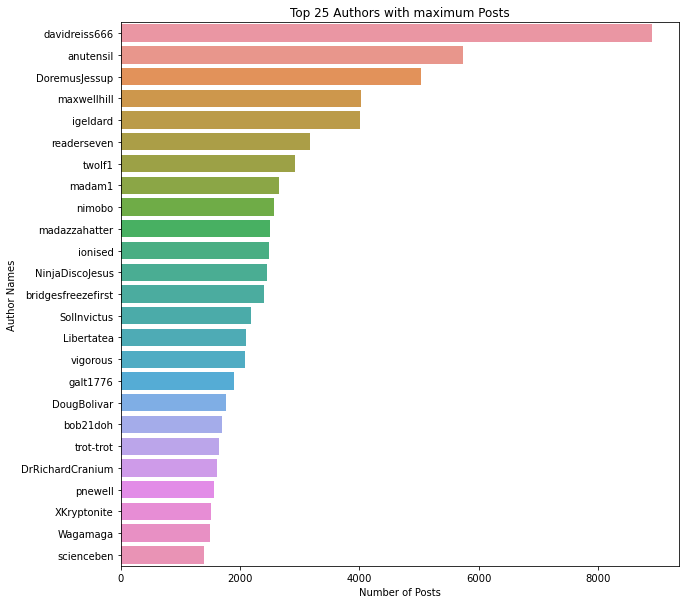

In [130]:
#plotting trend for top 25 authors with maximum posts.
num = 25
fig, ax = plt.subplots(figsize=(10,10))
g3 = sns.countplot(y=df['author'],order = df['author'].value_counts().iloc[:num].index, ax=ax)
g3.set_title(f'Top {num} Authors with maximum Posts')
g3.set(xlabel='Number of Posts', ylabel='Author Names')

In [131]:
#Generate data in dict that holds all the authors name and count of their posts:
author_post_count = dict(df['author'].value_counts()) 
sorted_keys_author_post_count = author_post_count.keys()
#Generate list of Top 10 authors with most posts: 
top10_active_authors = list(author_post_count.items())[:25]
top10_active_authors_names = []
#printing top 10 authors and their post counts
print('Top 25 Authors with Maximum Posts:')
print('        Name              Number of Posts')
for j, i in enumerate(top10_active_authors):
    top10_active_authors_names.append(i[0])
    print(f'{j:3}. {i[0]:20} {i[1]:10}')

Top 25 Authors with Maximum Posts:
        Name              Number of Posts
  0. davidreiss666              8897
  1. anutensil                  5730
  2. DoremusJessup              5037
  3. maxwellhill                4023
  4. igeldard                   4013
  5. readerseven                3170
  6. twolf1                     2923
  7. madam1                     2658
  8. nimobo                     2564
  9. madazzahatter              2503
 10. ionised                    2493
 11. NinjaDiscoJesus            2448
 12. bridgesfreezefirst         2405
 13. SolInvictus                2181
 14. Libertatea                 2108
 15. vigorous                   2077
 16. galt1776                   1897
 17. DougBolivar                1770
 18. bob21doh                   1698
 19. trot-trot                  1649
 20. DrRichardCranium           1616
 21. pnewell                    1562
 22. XKryptonite                1516
 23. Wagamaga                   1490
 24. scienceben                 139

[Text(0, 0.5, 'Author Names'), Text(0.5, 0, 'Number of Posts')]

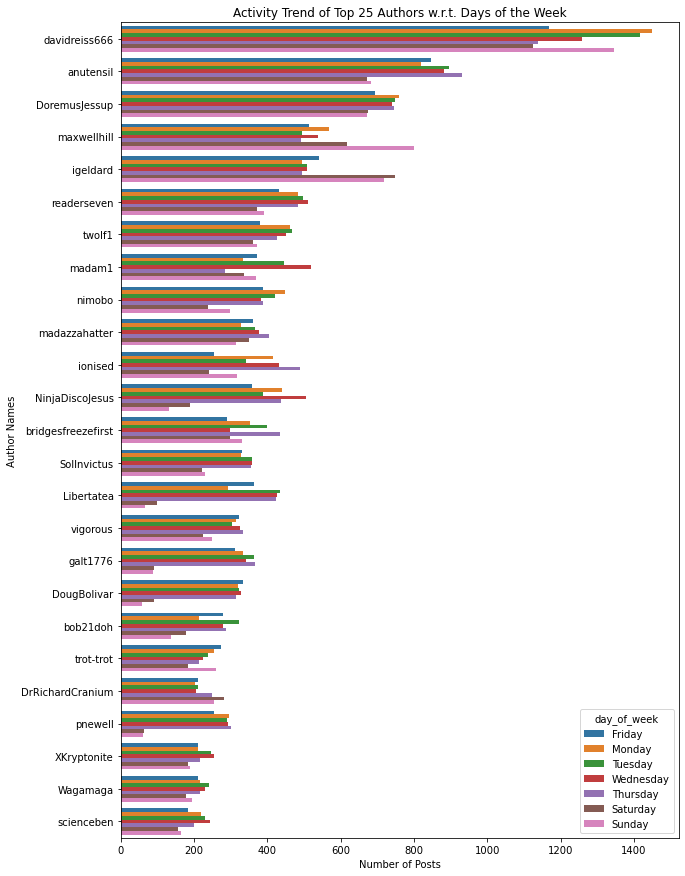

In [13]:
#plotting trend for to 25 active authors w.r.t. day of the week
fig = plt.figure(figsize=(10,15))
num = 25
g4 = sns.countplot(y=df['author'],order = df['author'].value_counts().iloc[:num].index, hue=df['day_of_week'])     
# plt.legend(loc='upper right') 
g4.set_title(f'Activity Trend of Top {num} Authors w.r.t. Days of the Week')
g4.set(xlabel='Number of Posts', ylabel='Author Names')

From the above graph we can conclude the following points:
1. All the top 25 authors post on all days of the week.
2. Majority of the authors psot more on the weekdays. Out of the top 25 authors, only 2 authors had trends that show higher posts during the weekends (maxwellhill and igeldard).

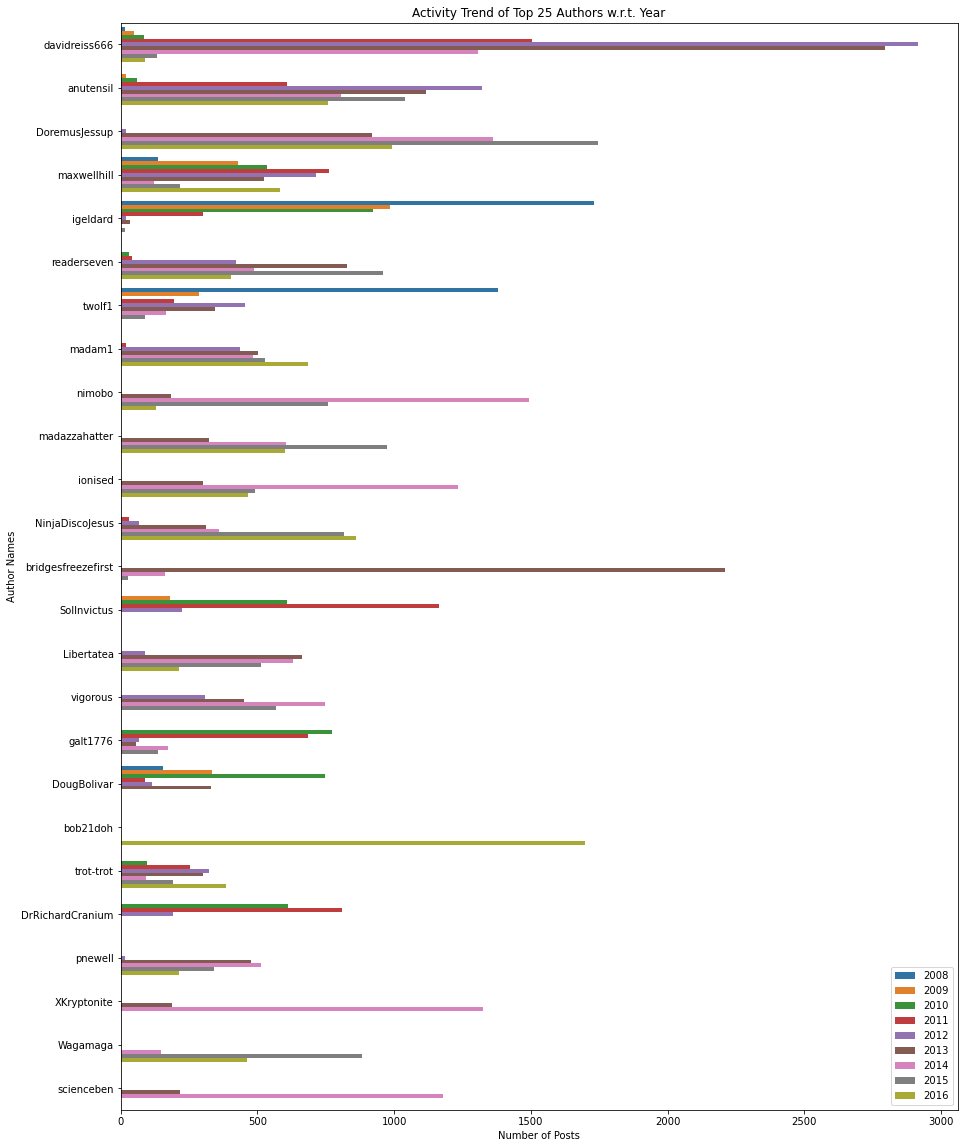

In [14]:
#plotting trend for to 25 active authors w.r.t. year
fig = plt.figure(figsize=(15,20))
num = 25
g5 = sns.countplot(y=df['author'],order = df['author'].value_counts().iloc[:num].index, hue=df['year'])     
g5.set_title('Activity Trend of Top 25 Authors w.r.t. Year')
g5.set(xlabel='Number of Posts', ylabel='Author Names')
plt.legend(loc='lower right')

From the above graph we can conclude the following points:
1. The top 25 authors are not much active in the recent years compared to previous years. 
2. There is no consistant grown in the number of news posted in consequent year among these top authors.

## Analysis 3: Most Popular Author Trends 
Most Popular = Author with maximum number of upvotes on his posts.

[Text(0, 0.5, 'Avg. Upvotes'), Text(0.5, 0, 'Days of the Week')]

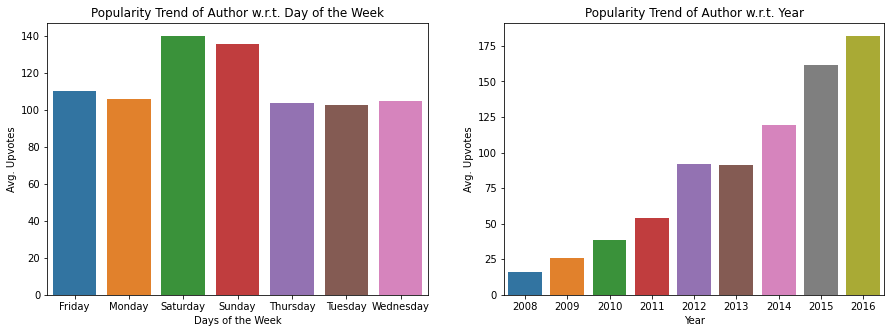

In [132]:
#plottig trends for avg.up votes v/s days of the week and year 
f, ax = plt.subplots(1, 2, figsize=(15, 5))
set1 = df.groupby('year').mean()['up_votes'].reset_index(name='avg_upvotes')
g6 = sns.barplot(x='year',y='avg_upvotes',data=set1, ax=ax[1])
g6.set_title('Popularity Trend of Author w.r.t. Year')
g6.set(xlabel='Year', ylabel='Avg. Upvotes')
set2 = df.groupby('day_of_week').mean()['up_votes'].reset_index(name='avg_upvotes')
g7 = sns.barplot(x='day_of_week',y='avg_upvotes',data=set2, ax=ax[0])
g7.set_title('Popularity Trend of Author w.r.t. Day of the Week')
g7.set(xlabel='Days of the Week', ylabel='Avg. Upvotes')

From the above graph it is clear that the news posted on weekends receive more upvotes. 
Also, the avg. upvotes have increased in the consecutive years. This shows more readers are getting involved in the news. 

[Text(0, 0.5, 'Authors'), Text(0.5, 0, 'Upvote Count')]

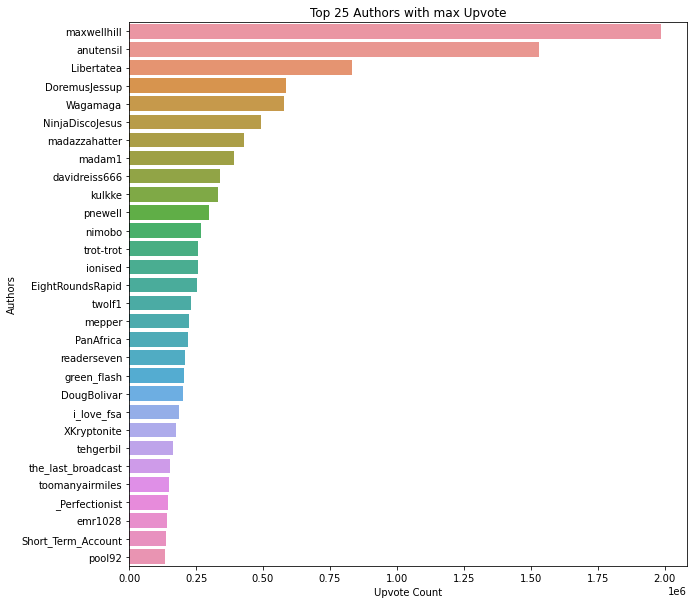

In [29]:
#plotting top 25 authors with maximum up votes.
f, ax = plt.subplots(figsize=(10, 10))
num = 30
set5 = df.groupby('author').sum()['up_votes'].reset_index(name='sum_votes').\
       sort_values(by='sum_votes',ascending=False)
g8 = sns.barplot(y='author',x='sum_votes',data=set5.iloc[:num],ax=ax)
g8.set_title('Top 25 Authors with max Upvote')
g8.set(xlabel='Upvote Count', ylabel='Authors')

In [66]:
#count number of upvotes gained by each author
up_votes_count = {}
for i in range(len(df)): #author cloumn is indexed 5 and up_votes cloumn indexed 2.
    if df.iloc[i,5] in up_votes_count: #[i,5] iterates through author column.
        up_votes_count[df.iloc[i,5]] += df.iloc[i,2] #[i,2] iterates through up_votes column. 
    else:
        up_votes_count[df.iloc[i,5]] = df.iloc[i,2]
#run time O(n)
#sorting the dict. \n",
sorted_up_votes_count = {}
sorted_keys_up_votes_count = sorted(up_votes_count, key=up_votes_count.get,reverse=True) #runtime O(n.logn)   
for w in sorted_keys_up_votes_count:
    sorted_up_votes_count[w] = up_votes_count[w]
    
top10_popular_authors = list(sorted_up_votes_count.items())[:25]
top10_popular_authors_names = []
for name in top10_popular_authors: #generate name list of most popular authors. 
    top10_popular_authors_names.append(name[0])

#printing top 10 authors and their total upvotes\n",
print(f'Top {num} Authors with Maximum Upvotes:')
print('        Name              Number of Upvotes')
for j, i in enumerate(top10_popular_authors):
    print(f'{j+1:3}. {i[0]:20} {i[1]:10}')

Top 25 Authors with Maximum Upvotes:
        Name              Number of Upvotes
  1. maxwellhill             1985416
  2. anutensil               1531544
  3. Libertatea               832102
  4. DoremusJessup            584380
  5. Wagamaga                 580121
  6. NinjaDiscoJesus          492582
  7. madazzahatter            428966
  8. madam1                   390541
  9. davidreiss666            338306
 10. kulkke                   333311
 11. pnewell                  297270
 12. nimobo                   266733
 13. trot-trot                258367
 14. ionised                  256159
 15. EightRoundsRapid         254670
 16. twolf1                   230031
 17. mepper                   223369
 18. PanAfrica                219742
 19. readerseven              209225
 20. green_flash              205554
 21. DougBolivar              199830
 22. i_love_fsa               187697
 23. XKryptonite              173604
 24. tehgerbil                161895
 25. the_last_broadcast       1

In [68]:
authors_most_popular_and_active = set(top10_popular_authors_names) & set(top10_active_authors_names)
authors_only_popular = set(top10_popular_authors_names) ^ (authors_most_popular_and_active)
authors_only_active = set(top10_active_authors_names) ^ authors_most_popular_and_active

dict_authors_most_popular_and_active = {} #holds author's popularity and activity rank respectively.
for every_name_key in authors_most_popular_and_active: #adding key to the dict. 
    dict_authors_most_popular_and_active[every_name_key] = []

popularity_rank = 1
activity_rank = 1
for i in dict_authors_most_popular_and_active:
    #get popularity rank on the author
    for each_tup in top10_popular_authors:  
        if i != each_tup[0]:
            popularity_rank += 1
        else: 
            dict_authors_most_popular_and_active[i].append(popularity_rank)
            popularity_rank = 1
            break
    #get total number of upvotes earned by the author
    for z in top10_popular_authors: 
        if z[0] == i:
            dict_authors_most_popular_and_active[i].append(z[1])
            break
        else:
            continue
    #get activity rank of the author
    for every_tup in top10_active_authors: 
        if i != every_tup[0]:
            activity_rank += 1
        else: 
            dict_authors_most_popular_and_active[i].append(activity_rank)
            activity_rank = 1
            break
    #get total number of posts by the author
    for y in top10_active_authors: 
        if y[0] == i:
            dict_authors_most_popular_and_active[i].append(y[1])
            break
        else:
            continue
del popularity_rank
del activity_rank

In [69]:
#generate Data Frame of Authors that are both popular and active
df_most_popular_and_active_authors = pd.DataFrame(data=dict_authors_most_popular_and_active, index=['Polularity Rank', 'Number of Upvotes', 'Activity Rank', 'Number of Posts'])
df_most_popular_and_active_authors = df_most_popular_and_active_authors.transpose()
df_top10_active_authors = pd.DataFrame(data = top10_active_authors_names, index=range(1,num+1), columns=['Name'])
df_top10_active_authors['Popularity Rank'] = popularity_rank_of_active_authors
print(f'List of Top {num} Authors that are both Popular and Active:')
df_most_popular_and_active_authors

List of Top 25 Authors that are both Popular and Active:


,Polularity Rank,Number of Upvotes,Activity Rank,Number of Posts
pnewell,11,297270,22,1562
DoremusJessup,4,584380,3,5037
XKryptonite,23,173604,23,1516
anutensil,2,1531544,2,5730
Wagamaga,5,580121,24,1490
Libertatea,3,832102,15,2108
readerseven,19,209225,6,3170
madazzahatter,7,428966,10,2503
DougBolivar,21,199830,18,1770
twolf1,16,230031,7,2923


In [70]:
#generate popularity rank of top 10 active authors.
popularity_rank = 1
popularity_rank_of_active_authors = []
for i in top10_active_authors_names:
    for j in sorted_keys_up_votes_count:
        if i == j: 
            popularity_rank_of_active_authors.append(popularity_rank)
            popularity_rank = 1
            break
        else:
            popularity_rank += 1
df_top10_active_authors = pd.DataFrame(data = top10_active_authors_names, index=range(1,num+1), columns=['Name'])
df_top10_active_authors['Popularity Rank'] = popularity_rank_of_active_authors
print(f'Popularity Ranking of Top {num} Active Authors:')
df_top10_active_authors

Popularity Ranking of Top 25 Active Authors:


,Name,Popularity Rank
1,davidreiss666,9
2,anutensil,2
3,DoremusJessup,4
4,maxwellhill,1
5,igeldard,101
6,readerseven,19
7,twolf1,16
8,madam1,8
9,nimobo,12
10,madazzahatter,7


In [71]:
#generate activity rank of top 25 popular authors\n",
activity_rank = 1
activity_rank_of_popular_authors = []
for i in top10_popular_authors_names:
    for j in sorted_keys_author_post_count:
        if i == j: 
            activity_rank_of_popular_authors.append(activity_rank)
            activity_rank = 1
            break
        else:
            activity_rank += 1

df_top10_popular_authors = pd.DataFrame(data = top10_popular_authors_names, index=range(1,num+1), columns=['Name'])
df_top10_popular_authors['Activity Rank'] = activity_rank_of_popular_authors
print(f'Activity Ranking of Top {num} Popular Authors:')
df_top10_popular_authors

Activity Ranking of Top 25 Popular Authors:


,Name,Activity Rank
1,maxwellhill,4
2,anutensil,2
3,Libertatea,15
4,DoremusJessup,3
5,Wagamaga,24
6,NinjaDiscoJesus,12
7,madazzahatter,10
8,madam1,8
9,davidreiss666,1
10,kulkke,28


In [134]:
#finding authors that are popular and active but have plagrised content.
authors_popular_but_plag = set(top10_popular_authors_names) & set(top10_plag_authors_names)
print(f'Authors that are in top {num} popular list but have plagirised content: {authors_popular_but_plag}')
authors_active_but_plag = set(top10_active_authors_names) & set(top10_plag_authors_names)
print(f'Authors that are in top {num} active list but have plagrisied content: {authors_active_but_plag}')
authors_active_popular_but_plag = set(top10_popular_authors_names) & set(top10_active_authors_names) & set(top10_plag_authors_names)
print(f'Authors that are in both top {num} popular and active list but have plagirised content: {authors_active_popular_but_plag}')

Authors that are in top 25 popular list but have plagirised content: {'DoremusJessup', 'nimobo', 'readerseven'}
Authors that are in top 25 active list but have plagrisied content: {'DoremusJessup', 'readerseven', 'bob21doh', 'scienceben', 'nimobo'}
Authors that are in both top 25 popular and active list but have plagirised content: {'DoremusJessup', 'nimobo', 'readerseven'}


From the above analysis we can conclude: 
1. Having more posts doesnot make you a popular author. 
2. Also, being a popular author doesnot guarantee that the author is highly active. 
3. Some authors that have high popularty or activity rank or both have plagrised content.

## Analysis 4: Adult Content in the News
The column ['over_18] indicates if the content in the news is adult rated.

In [77]:
df_adult_content_news = df.loc[df['over_18'] == True]
df_adult_content_news.head()
print(f'There are a total of {len(df_adult_content_news)} adult rated news titles in the dataset.')
print(f'This is {round(len(df_adult_content_news)/len(df)*100,2)}% of the total dataset.')
no_authors = set(df_adult_content_news['author'])
print(f'Number of authors that have published adult rated news: {len(no_authors)}')

There are a total of 320 adult rated news titles in the dataset.
This is 0.06% of the total dataset.
Number of authors that have published adult rated news: 285


# Analysis 5: Working with the Title

D:\Anaconda\application\envs\nlp_course\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
D:\Anaconda\application\envs\nlp_course\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


[Text(0, 0.5, 'Average Upvotes'), Text(0.5, 0, 'Length of the Title')]

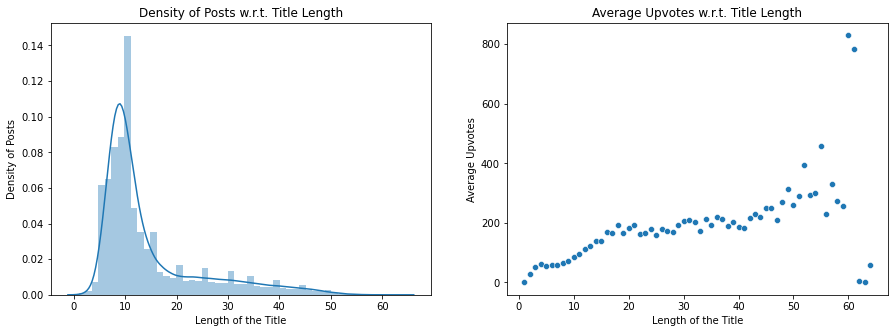

In [79]:
#plotting trend with the length of the title and upvotes. 
f, ax = plt.subplots(1, 2, figsize=(15, 5))
g9 = sns.distplot(df['title_length'],ax=ax[0])
g9.set_title('Density of Posts w.r.t. Title Length')
g9.set(xlabel='Length of the Title', ylabel='Density of Posts')
set6 = df.groupby('title_length').mean()['up_votes'].reset_index(name='avg_votes')
g10 = sns.scatterplot(set6['title_length'],set6['avg_votes'],ax=ax[1])
g10.set_title('Average Upvotes w.r.t. Title Length')
g10.set(xlabel='Length of the Title', ylabel='Average Upvotes')

Most of the titles int he dataset have roughly 10 words. 
With increase in the length of the title, upvotes increase. But if the length exceeds 50-55 (i.e. if the title is too long) the upvotes drop drastically. 

[Text(0, 0.5, 'Country'), Text(0.5, 0, 'Number of Posts')]

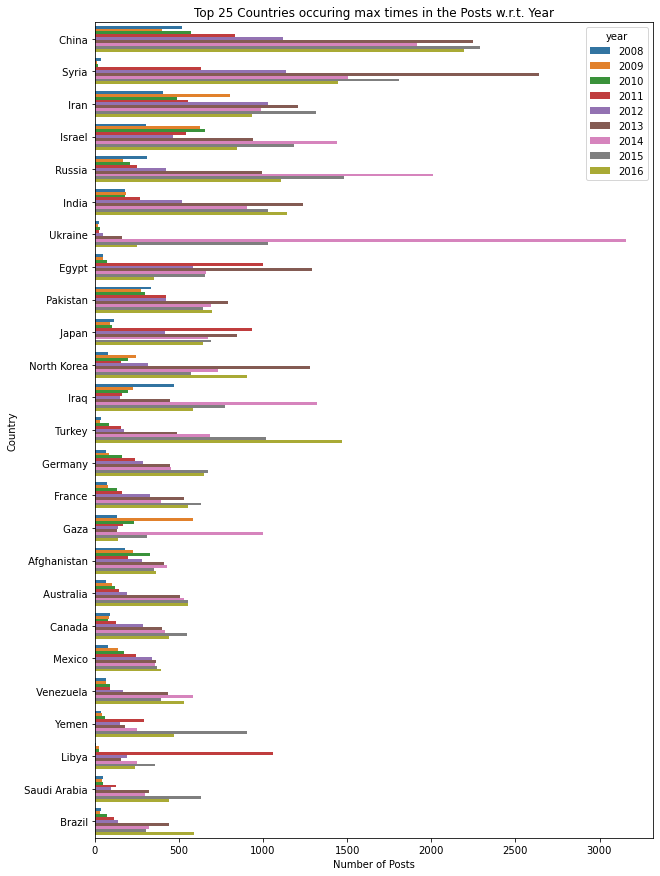

In [84]:
#plotting top 25 countries with max number of posts w.r.t. year.  
fig = plt.figure(figsize=(10,15))
num = 25
g11 = sns.countplot(y=df['countries'],order = df['countries'].value_counts().iloc[:num].index, hue=df['year'])
g11.set_title(f'Top {num} Countries occuring max times in the Posts w.r.t. Year')
g11.set(xlabel='Number of Posts', ylabel='Country')

## Natural Language Processing
### Sentiment Analysis with VADER:
While the scope of sentiment analysis is very broad, we will only focus our work:

#### Polarity classification
We won't try to determine if a sentence is objective or subjective, fact or opinion. Rather, we care nly if the text expresses a *positive*, *negative* or *neutral* opinion.

#### NLTK's VADER module
VADER is an NLTK module that provides sentiment scores based on words used (\"completely\" boosts a core, while \"slightly\" reduces it), on capitalization & punctuation (\"GREAT!!!\" is stronger than "great.\"), and negations (words like \"isn't\" and \"doesn't\" affect the outcome).
To view the source code visit https://www.nltk.org/_modules/nltk/sentiment/vader.html

VADER's `SentimentIntensityAnalyzer()` takes in a string and returns a dictionary of scores in each f four categories:
* negative
* neutral
* positive
* compound *(computed by normalizing the scores above)*

In [85]:
#sentiment analysis with VADER
sid = SentimentIntensityAnalyzer()
scores = df['title'].apply(lambda title: sid.polarity_scores(title))
compound  = scores.apply(lambda score_dict: score_dict['compound'])
df['Title Sentiment'] = compound.apply(lambda c: 'Positive' if c > 0 else ('Neutral' if c == 0 else 'Negative'))
df.head()

,time_created,date_created,up_votes,title,over_18,author,plagiarised,day_of_week,day_of_week_num,year,month,day,weekend,day_time,author_total_posts,title_length,countries,places,Title Sentiment
0,2008-01-25 03:34:06,2008-01-25,3,Scores killed in Pakistan clashes,0,polar,False,Friday,4,2008,1,25,0,3.568333,50,5,Pakistan,1,Negative
1,2008-01-25 03:34:35,2008-01-25,2,Japan resumes refuelling mission,0,polar,False,Friday,4,2008,1,25,0,3.576389,50,4,Japan,1,Neutral
2,2008-01-25 03:42:03,2008-01-25,3,US presses Egypt on Gaza border,0,polar,False,Friday,4,2008,1,25,0,3.700833,50,6,Egypt Gaza,2,Neutral
3,2008-01-25 03:54:50,2008-01-25,1,Jump-start economy: Give health care to all,0,fadi420,False,Friday,4,2008,1,25,0,3.913889,2,7,NaN,0,Positive
4,2008-01-25 15:25:20,2008-01-25,4,Council of Europe bashes EU&UN terror blacklist,0,mhermans,False,Friday,4,2008,1,25,0,15.422222,1,7,NaN,0,Negative


In [86]:
df_sentiments = pd.DataFrame(data=df['Title Sentiment'].value_counts())
sentiment_count = list(df['Title Sentiment'].value_counts())
df_sentiments['% of Total Posts'] = [round((sentiment_count[0]/len(title))*100,2), round((sentiment_count[1]/len(title))*100,2),round((sentiment_count[2]/len(title))*100,2)]    
df_sentiments

,Title Sentiment,% of Total Posts
Negative,268870,53.70
Neutral,138643,27.69
Positive,101717,20.31


In [21]:
#sentiments in adult rated content
df_sentiments_adult_rated_news = df.loc[df['over_18'] == True]
df_sentiments_adult = pd.DataFrame(data=df_sentiments_adult_rated_news['Title Sentiment'].value_counts())
sentiment_count_adult = list(df_sentiments_adult_rated_news['Title Sentiment'].value_counts())
df_sentiments_adult['% of Total Adult Posts'] = [round((sentiment_count_adult[0]/len(df_sentiments_adult_rated_news))*100,2), round((sentiment_count_adult[1]/len(df_sentiments_adult_rated_news))*100,2),round((sentiment_count_adult[2]/len(df_sentiments_adult_rated_news))*100,2)]
df_sentiments_adult['% of Total Posts'] = [round((sentiment_count_adult[0]/len(title))*100,2), round((sentiment_count_adult[1]/len(title))*100,2),round((sentiment_count_adult[2]/len(title))*100,2)]
df_sentiments_adult

,Title Sentiment,% of Total Adult Posts,% of Total Posts
Negative,208,65.00,0.04
Neutral,71,22.19,0.01
Positive,41,12.81,0.01


# LDA - Latent Dirichlet Allocation for Clustering Titles
### Unsupervised Machine Learning
 - This is slow but effective

In [87]:
#preprocessing
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(max_df=0.95, min_df=2, stop_words='english') 
dtm = cv.fit_transform(df['title'])
dtm

<509230x51080 sparse matrix of type '<class 'numpy.int64'>'
	with 4762981 stored elements in Compressed Sparse Row format>

In [88]:
#LDA
from sklearn.decomposition import LatentDirichletAllocation
LDA = LatentDirichletAllocation(n_components=7,random_state=42) #making clusters of seven
LDA.fit(dtm)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='batch', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=7, n_jobs=None, n_topics=None, perp_tol=0.1,
             random_state=42, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)

In [89]:
for index,topic in enumerate(LDA.components_):
    print(f'THE TOP 15 WORDS FOR TOPIC #{index}')
    print([cv.get_feature_names()[i] for i in topic.argsort()[-15:]])
    print('\n')

THE TOP 15 WORDS FOR TOPIC #0
['arabia', 'says', 'sea', 'chinese', 'new', 'russia', 'nuclear', 'iran', 'india', 'military', 'saudi', 'south', 'north', 'korea', 'china']


THE TOP 15 WORDS FOR TOPIC #1
['million', 'years', 'old', 'air', 'killed', 'people', 'al', 'isis', 'syrian', 'iraq', 'year', 'syria', 'islamic', 'state', '000']


THE TOP 15 WORDS FOR TOPIC #2
['kills', 'taliban', 'suicide', 'afghanistan', 'afghan', 'woman', 'pakistan', 'bbc', 'dead', 'attack', 'man', 'killed', 'death', 'police', 'news']


THE TOP 15 WORDS FOR TOPIC #3
['hamas', 'group', 'says', 'syria', 'terror', 'human', 'attacks', 'palestinian', 'egypt', 'attack', 'rights', 'gaza', 'war', 'israeli', 'israel']


THE TOP 15 WORDS FOR TOPIC #4
['water', 'change', 'billion', 'says', 'power', 'bank', 'oil', 'government', 'climate', 'global', 'uk', 'japan', 'china', 'new', 'world']


THE TOP 15 WORDS FOR TOPIC #5
['election', 'government', 'russian', 'obama', 'talks', 'putin', 'new', 'deal', 'ukraine', 'syria', 'says', '

In [99]:
#Attaching Discovered Topic Labels to Original Articles
topic_results = LDA.transform(dtm)
#Combining with Original Data
topic_results.argmax(axis=1)
df['LDA Topic'] = topic_results.argmax(axis=1)
#adding names to the clusters. Names are assignes according to best of my knowledge. 
myTopics_LDA = {0:'East Asian Country', 1:'Middle-East Asian Countries War', 2:'Terror Attacks', 3:'Middle-East Asian Countries Politics', 4:'Global', 5:'Politics', 6:'Agitation'}
df['LDA Topic'] = df['LDA Topic'].map(myTopics_LDA)
df.head(10)

,time_created,date_created,up_votes,title,over_18,author,plagiarised,day_of_week,day_of_week_num,year,...,day,weekend,day_time,author_total_posts,title_length,countries,places,Title Sentiment,LDA Topic,NMF Topic
0,2008-01-25 03:34:06,2008-01-25,3,Scores killed in Pakistan clashes,0,polar,False,Friday,4,2008,...,25,0,3.568333,50,5,Pakistan,1,Negative,Terror Attacks,East Asian Country
1,2008-01-25 03:34:35,2008-01-25,2,Japan resumes refuelling mission,0,polar,False,Friday,4,2008,...,25,0,3.576389,50,4,Japan,1,Neutral,East Asian Country,South and East Asian Countries Military Disputes
2,2008-01-25 03:42:03,2008-01-25,3,US presses Egypt on Gaza border,0,polar,False,Friday,4,2008,...,25,0,3.700833,50,6,Egypt Gaza,2,Neutral,Middle-East Asian Countries Politics,Wester Asia
3,2008-01-25 03:54:50,2008-01-25,1,Jump-start economy: Give health care to all,0,fadi420,False,Friday,4,2008,...,25,0,3.913889,2,7,NaN,0,Positive,Global,East Asian Country
4,2008-01-25 15:25:20,2008-01-25,4,Council of Europe bashes EU&UN terror blacklist,0,mhermans,False,Friday,4,2008,...,25,0,15.422222,1,7,NaN,0,Negative,Politics,European Politics
5,2008-01-25 19:04:49,2008-01-25,15,Hay presto! Farmer unveils the illegal mock-...,0,Armagedonovich,False,Friday,4,2008,...,25,0,19.080278,2,16,NaN,0,Negative,Global,East Asian Country
6,2008-01-25 19:30:38,2008-01-25,5,"Strikes, Protests and Gridlock at the Poland-U...",0,Clythos,False,Friday,4,2008,...,25,0,19.510556,6,8,NaN,0,Negative,East Asian Country,European Politics
7,2008-01-28 16:11:02,2008-01-28,0,The U.N. Mismanagement Program,0,Moldavite,False,Monday,0,2008,...,28,0,16.183889,362,4,NaN,0,Neutral,Global,East-Asia Politics
8,2008-01-28 22:13:16,2008-01-28,4,Nicolas Sarkozy threatens to sue Ryanair,0,Moldavite,False,Monday,0,2008,...,28,0,22.221111,362,6,NaN,0,Negative,Politics,East Asian Countries
9,2008-01-29 19:44:29,2008-01-29,3,US plans for missile shields in Polish town me...,0,JoeyRamone63,False,Tuesday,1,2008,...,29,0,19.741389,30,12,NaN,0,Neutral,Middle-East Asian Countries Politics,East Asian Countries


[Text(0, 0.5, 'LDA Categories'), Text(0.5, 0, 'Number of Posts')]

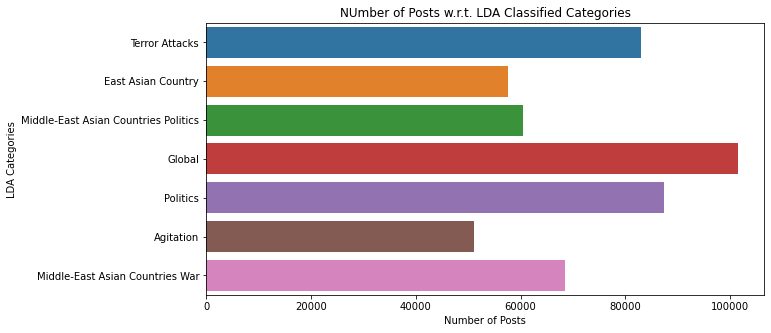

In [109]:
#plotting number of posts w.r.t. LDA categories
fig = plt.figure(figsize=(10,5))
g12 = sns.countplot(y='LDA Topic',data=df)
g12.set_title(f'Number of Posts w.r.t. LDA Classified Categories')
g12.set(xlabel='Number of Posts', ylabel='LDA Categories')

[Text(0, 0.5, 'Author'), Text(0.5, 0, 'Number of Posts')]

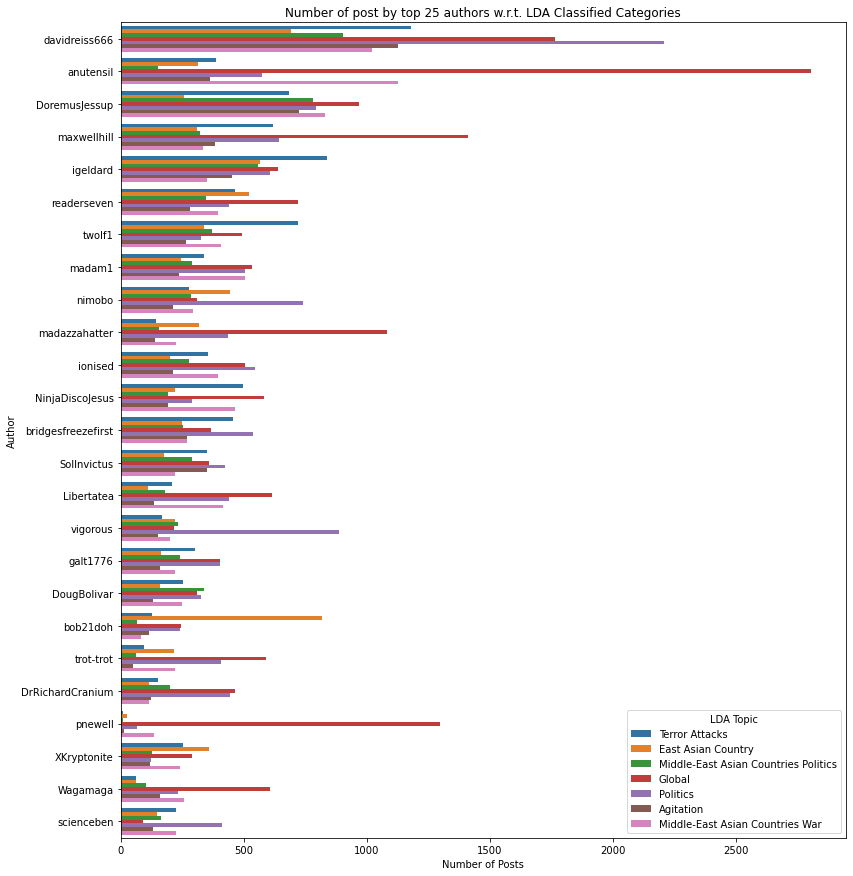

In [120]:
#plotting number of posts done by top 25 authors in each LDA category
fig = plt.figure(figsize=(13,15))
g13 = sns.countplot(y=df['author'],order = df['author'].value_counts().iloc[:num].index, hue=df['LDA Topic'])
g13.set_title(f'Number of post by top {num} authors w.r.t. LDA Classified Categories')
g13.set(xlabel='Number of Posts', ylabel='Author')

[Text(0, 0.5, 'Author'), Text(0.5, 0, 'Number of Upvotes')]

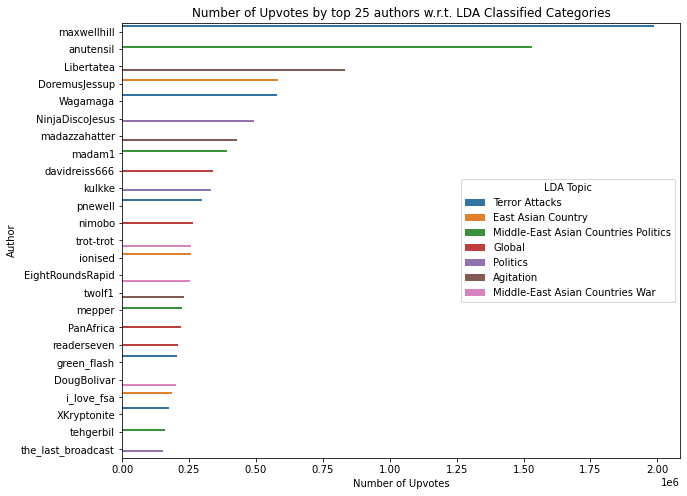

In [121]:
#plotting number of upvotes gained by top 25 authors in each its LDA category
fig = plt.figure(figsize=(10,8))
set7 = df.groupby('author').sum()['up_votes'].reset_index(name='sum_votes').\
       sort_values(by='sum_votes',ascending=False)
g14 = sns.barplot(y='author',x='sum_votes',data=set7.iloc[:num], hue=df['LDA Topic'])
g14.set_title(f'Number of Upvotes gained by top {num} authors w.r.t. LDA Classified Categories')
g14.set(xlabel='Number of Upvotes', ylabel='Author')

The graph gives an insight that the most popular authors have their popularity in one and only one LDA category i.e. when they post news of similar kind, they get more upvotes. 

# NMF - Non Negative Matrix Factorization for Clustering Titles
### Unsupervised Machine Learning
 - Faster than LDA

In [91]:
#preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')
dtm = tfidf.fit_transform(df['title'])
dtm

<509230x51080 sparse matrix of type '<class 'numpy.float64'>'
	with 4762981 stored elements in Compressed Sparse Row format>

In [92]:
#NMF
from sklearn.decomposition import NMF
nmf_model = NMF(n_components=7,random_state=42)
nmf_model.fit(dtm)

NMF(alpha=0.0, beta_loss='frobenius', init=None, l1_ratio=0.0, max_iter=200,
  n_components=7, random_state=42, shuffle=False, solver='cd', tol=0.0001,
  verbose=0)

In [93]:
#Displaying Topics
for index,topic in enumerate(nmf_model.components_):
    print(f'THE TOP 15 WORDS FOR TOPIC #{index}')
    print([tfidf.get_feature_names()[i] for i in topic.argsort()[-15:]])
    print('\n')

THE TOP 15 WORDS FOR TOPIC #0
['iraq', 'syrian', 'dead', 'world', 'news', 'pakistan', 'islamic', 'says', 'government', 'people', 'new', 'state', 'police', 'attack', 'killed']


THE TOP 15 WORDS FOR TOPIC #1
['missiles', 'japan', 'threatens', 'war', 'says', 'launch', 'jong', 'test', 'kim', 'missile', 'nuclear', 'korean', 'south', 'north', 'korea']


THE TOP 15 WORDS FOR TOPIC #2
['dispute', 'philippines', 'islands', 'taiwan', 'disputed', 'beijing', 'military', 'india', 'new', 'world', 'chinese', 'japan', 'south', 'sea', 'china']


THE TOP 15 WORDS FOR TOPIC #3
['gas', 'europe', 'moscow', 'president', 'crimea', 'nato', 'military', 'crisis', 'sanctions', 'eu', 'says', 'putin', 'russian', 'ukraine', 'russia']


THE TOP 15 WORDS FOR TOPIC #4
['power', 'program', 'japan', 'iranian', 'oil', 'arabia', 'plant', 'obama', 'saudi', 'sanctions', 'says', 'talks', 'deal', 'nuclear', 'iran']


THE TOP 15 WORDS FOR TOPIC #5
['conflict', 'aleppo', 'air', 'iraq', 'strikes', 'al', 'isis', 'weapons', 'turk

In [94]:
#Attaching Discovered Topic Labels to Original Articles
topic_results = nmf_model.transform(dtm)
#Combining with Original Data
df['NMF Topic'] = topic_results.argmax(axis=1)
myTopics_NMF = {0:'East Asian Country', 1:'East Asian Countries', 2:'South and East Asian Countries Military Disputes', 3:'European Politics', 4:'East-Asia Politics', 5:'Middle-Eastern Countries War', 6:'Wester Asia'}
df['NMF Topic'] = df['NMF Topic'].map(myTopics_NMF)
df.head()

,time_created,date_created,up_votes,title,over_18,author,plagiarised,day_of_week,day_of_week_num,year,...,day,weekend,day_time,author_total_posts,title_length,countries,places,Title Sentiment,LDA Topic,NMF Topic
0,2008-01-25 03:34:06,2008-01-25,3,Scores killed in Pakistan clashes,0,polar,False,Friday,4,2008,...,25,0,3.568333,50,5,Pakistan,1,Negative,Terror Attacks,East Asian Country
1,2008-01-25 03:34:35,2008-01-25,2,Japan resumes refuelling mission,0,polar,False,Friday,4,2008,...,25,0,3.576389,50,4,Japan,1,Neutral,East Asian Country,South and East Asian Countries Military Disputes
2,2008-01-25 03:42:03,2008-01-25,3,US presses Egypt on Gaza border,0,polar,False,Friday,4,2008,...,25,0,3.700833,50,6,Egypt Gaza,2,Neutral,Middle-East Asian Countries Politics,Wester Asia
3,2008-01-25 03:54:50,2008-01-25,1,Jump-start economy: Give health care to all,0,fadi420,False,Friday,4,2008,...,25,0,3.913889,2,7,NaN,0,Positive,Environment,East Asian Country
4,2008-01-25 15:25:20,2008-01-25,4,Council of Europe bashes EU&UN terror blacklist,0,mhermans,False,Friday,4,2008,...,25,0,15.422222,1,7,NaN,0,Negative,Politics,European Politics


[Text(0, 0.5, 'Author'), Text(0.5, 0, 'Number of Posts')]

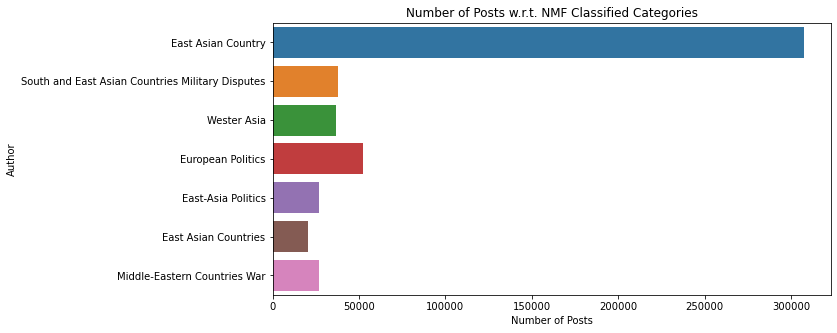

In [124]:
#plotting number of posts w.r.t. NMF categories 
fig = plt.figure(figsize=(10,5))
g15 =sns.countplot(y='NMF Topic',data=df)
g15.set_title(f'Number of Posts w.r.t. NMF Classified Categories')
g15.set(xlabel='Number of Posts', ylabel='Author')

[Text(0, 0.5, 'Author'), Text(0.5, 0, 'Number of Posts')]

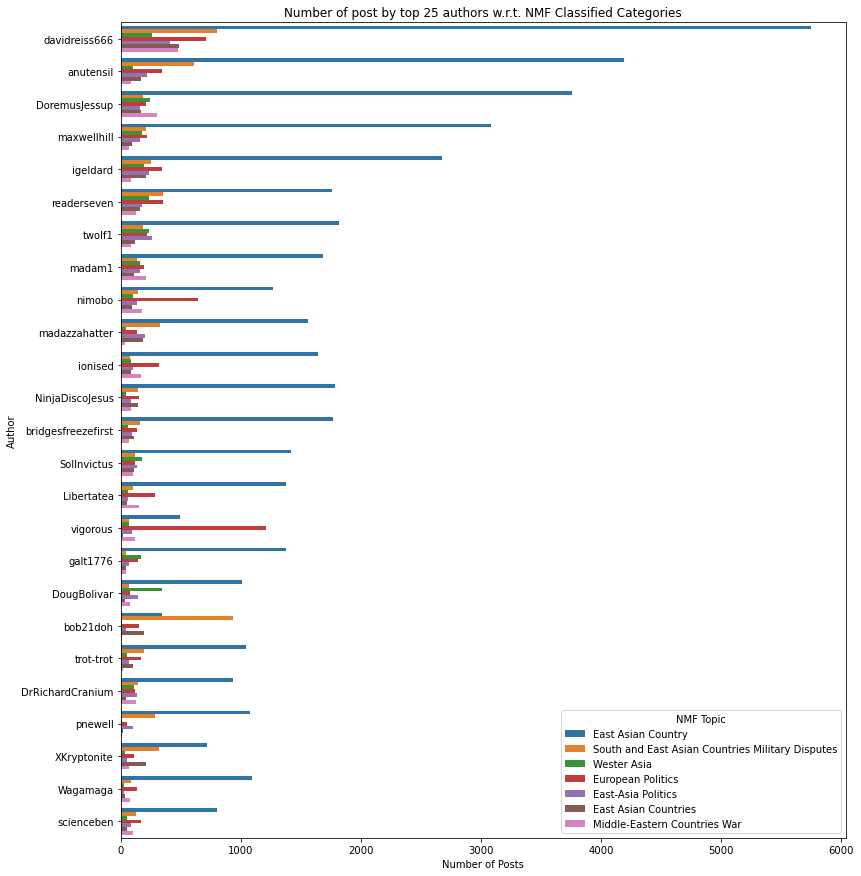

In [125]:
#plotting number of posts done by top 25 authors in each LNMF category
fig = plt.figure(figsize=(13,15))
g16 = sns.countplot(y=df['author'],order = df['author'].value_counts().iloc[:num].index, hue=df['NMF Topic'])
g16.set_title(f'Number of post by top {num} authors w.r.t. NMF Classified Categories')
g16.set(xlabel='Number of Posts', ylabel='Author')

[Text(0, 0.5, 'Author'), Text(0.5, 0, 'Number of Upvotes')]

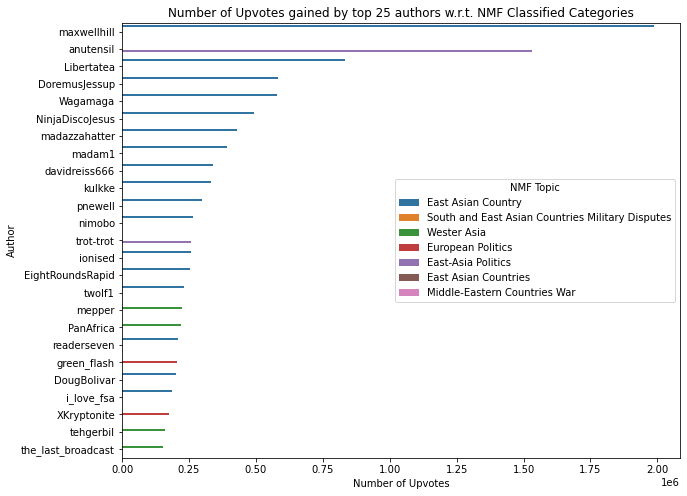

In [136]:
#plotting number of upvotes gained by top 25 authors in each its NMF category
fig = plt.figure(figsize=(10,8))
set9 = df.groupby('author').sum()['up_votes'].reset_index(name='sum_votes').\
       sort_values(by='sum_votes',ascending=False)
g15 = sns.barplot(y='author',x='sum_votes',data=set9.iloc[:num], hue=df['NMF Topic'])
g15.set_title(f'Number of Upvotes gained by top {num} authors w.r.t. NMF Classified Categories')
g15.set(xlabel='Number of Upvotes', ylabel='Author')

This graph gives an insite that one single category dominates in the terms of upvotes adn post counts.But again we see that each author receives upvotes in one and only one category. 

Applying both LDA and NMF, the categories by LDA are much more uniformly distributed where as, NMF is not. But LDA takes longer time for computation. It highly depends on the domain expert which classification to choose. 

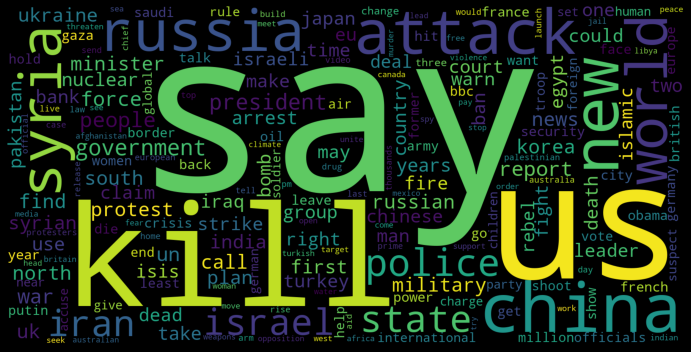

In [135]:
#Word Cloud
lemma=WordNetLemmatizer() 
stopwords_en = stopwords.words('english')

def text_process(text):
    # Clean the text
    #text = re.sub(r"[^A-Za-z0-9(),!?@\'\`\"\_\n]", " ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", "", text)
    text = re.sub(r"U-turn", "Uturn", text)
    text = re.sub(r"New York Times", "NewYorkTimes", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"U of", "University of", text)
    text = re.sub(r"N Korea", "NorthKorea", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r"U S", "US", text)
    text = re.sub(r"U S ", "US", text)
    text = re.sub(r"U N", "UN", text)
    text = re.sub(r"U N ", "UN", text)
    text = re.sub(r"@\S+", "", text)

    word=nltk.word_tokenize(text.lower())
    new_word=[w for w in word if w not in stopwords_en and w.isalpha()]
    new_word=[lemma.lemmatize(w, "v") for w in new_word]
    #new_word=[stemmer.stem(w) for w in new_word]
    return new_word

def word_freq(s):
    txt = s.str.lower().str.cat(sep=' ')  
    words = text_process(txt)
    words_dist = nltk.FreqDist(w for w in words) 
    return words_dist

def plot_cloud(words_dist,size):
    wordcloud = WordCloud(width=1600, height=800,
                          background_color='black').generate_from_frequencies(words_dist)
    fig = plt.figure(figsize=size, facecolor='k')
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.tight_layout()
    plt.show()
for year in range(2008, 2017):
    words_dist=word_freq(df[df['year']==year]['title'])
    res=[]
    for w, count in words_dist.most_common(10):
        res.append(w)
    #print(year, res)
words_dist=word_freq(df['title'])
len(words_dist)
words_dist
plot_cloud(words_dist,size = (15,5)) 

# Thank You!                    :)